In [2]:
import os
import numpy as np
import pandas as pd

from utils import njit, copy_filter_hp_to_other_clock_frequency
from utils import timing
from pathlib import Path
from snn.graphs import plot_network
from matplotlib import pyplot as plt
from snn.resonator import create_excitatory_inhibitory_resonator

%matplotlib inline

ModuleNotFoundError: No module named 'numba'

In [2]:
@njit
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_sine_wave(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size

def custom_resonator_output_spikes(
        freq0,
        clk_freq=int(1.536 * (10 ** 6)) * 2,
        step=1/12_000,
        save_figure=False,
        spectrum=None,
        path=None,
        plot=True
):
    my_resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
    log_neuron_potentials = []
    for i in log_neuron_potentials:
        my_resonator.log_membrane_potential(i)
    my_resonator.log_out_spikes(-1)
    start_freq = 0
    spectrum = spectrum or 2 * freq0
    test_size = int(spectrum / step)
    spikes_neuron = my_resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    for i in log_neuron_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    y_spikes = spikes_neuron.out_spikes[:spikes_neuron.index]

    if path is not None:
        np.savez_compressed(path,
                            spikes=y_spikes)

    spikes_window_size = 5000
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()

In [3]:
clk_filters = {
    696172: (30, 63),
    331510: (14, 30),
    154705: (8, 14),
    88402: (4, 8),
    16830: (0, 4),
}
for clk_freq, (lower_f, higher_f) in clk_filters.items():
    for fname in os.listdir(f'../filters/clk_{clk_freq}/parameters'):
        f0 = float(fname[2:-5])
        spikes_file = f'../spikes_output/{f0:.3f}.npz'
        if Path(spikes_file).is_file():
            continue
        if not lower_f <= f0 <= higher_f:
            continue
        custom_resonator_output_spikes(f0, clk_freq, 1/1_000_000, save_figure=False,spectrum=80, path=f'../spikes_output/{f0:.3f}.npz', plot=False)

In [4]:
def generate_figures(clk_freq, step):
    if not os.path.isdir(f'../filters/clk_{clk_freq}/figures'):
        os.makedirs(f'../filters/clk_{clk_freq}/figures')
    already_exist = os.listdir(f'../filters/clk_{clk_freq}/figures')
    already_exist = [f'{float(f[2:-4]):.3f}' for f in already_exist]
    for fname in os.listdir(f'../filters/clk_{clk_freq}/parameters'):
        if fname[2:-5] in already_exist:
            continue
        f0 = float(fname[2:-5])
        print(f0)
        custom_resonator_output_spikes(
            f0,
            clk_freq=clk_freq,
            step=1/step,
            save_figure=True
        )
        gc.collect()

In [28]:
generate_figures(2245, 5_000_000)

0.088
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x00000197F3CFF550>,), {'start_freq': 0, 'step': 2e-07, 'test_size': 880000, 'clk_freq': 2245}] took: 3.3060 sec
0.102
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x00000197F52AB670>,), {'start_freq': 0, 'step': 2e-07, 'test_size': 1020000, 'clk_freq': 2245}] took: 3.8695 sec
0.132
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x00000197F52AB310>,), {'start_freq': 0, 'step': 2e-07, 'test_size': 1320000, 'clk_freq': 2245}] took: 4.8399 sec
0.146
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x00000197F689E430>,), {'start_freq': 0, 'step': 2e-07, 'test_size': 1460000, 'clk_freq': 2245}] took: 5.3214 sec
0.24
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x00000197F6699D60>,), {'start_freq': 0, 'step': 2e-07, 'test_size': 2400000

In [ ]:
import gc

already_exist = os.listdir('../filters/clk_3072000/figures')
already_exist = [f'{float(f[2:-4])}' for f in already_exist]
for fname in list(os.listdir('../filters/clk_3072000/parameters'))[6:]:
    f0 = int(fname[2:-5])
    print(f0)
    custom_resonator_output_spikes(f0, clk_freq=3072000, save_figure=True)
    gc.collect()

1719
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x000001E1D5860970>,), {'start_freq': 0, 'step': 8.333333333333333e-05, 'test_size': 41256000, 'clk_freq': 3072000}] took: 78.6562 sec
180
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x000001E202BD02E0>,), {'start_freq': 0, 'step': 8.333333333333333e-05, 'test_size': 4320000, 'clk_freq': 3072000}] took: 8.6440 sec
200
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x000001E21D5D3400>,), {'start_freq': 0, 'step': 8.333333333333333e-05, 'test_size': 4800000, 'clk_freq': 3072000}] took: 9.3393 sec
2029
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x000001E202CA7130>,), {'start_freq': 0, 'step': 8.333333333333333e-05, 'test_size': 48696000, 'clk_freq': 3072000}] took: 94.9503 sec
236
func:test_frequency args:((<numba.experimental.jitclass.boxing.SpikingNetwork object at 0x

In [13]:
copy_filter_hp_to_other_clock_frequency(3072000, 35330)

In [7]:
4*3072000/278

44201.438848920865

In [8]:
# 63
copy_filter_hp_to_other_clock_frequency(3072000, 696172)
# 30
copy_filter_hp_to_other_clock_frequency(3072000, 331510)
# 14
copy_filter_hp_to_other_clock_frequency(3072000, 154705)
# 8
copy_filter_hp_to_other_clock_frequency(3072000, 88402)

In [7]:

def interpolate_spikes(spikes_array, sum_window=100):
  spikes_array = np.convolve(spikes_array, np.ones(sum_window, dtype=np.int8), 'valid')
  return spikes_array

def plot_spikes_spectogram(
        output_spikes,
):
    spikes_heatmap = pd.DataFrame.from_dict(output_spikes)
    spikes_heatmap = spikes_heatmap.reindex(sorted(spikes_heatmap.columns), axis=1).T
    spikes_heatmap_data = spikes_heatmap.to_numpy()
    plt.figure(figsize=(14, 5))
    plt.imshow(spikes_heatmap_data, cmap='viridis', aspect='auto', origin='lower',
               vmin=np.min(spikes_heatmap_data), vmax=np.max(spikes_heatmap_data),
               extent=[0, 80, 0, len(spikes_heatmap.index)])
    plt.yticks(range(len(spikes_heatmap.index)), spikes_heatmap.index)
    plt.title(f'Spikes spectogram')
    plt.colorbar()
    plt.show()


In [37]:
spikes_data = {
    ('0' * (6-len(filename[:-4]))) + filename[:-4]: interpolate_spikes(
        np.load(f'../spikes_output/{filename}')['spikes'].astype(np.int8),
        200
    )
    for filename in os.listdir('../spikes_output')
}

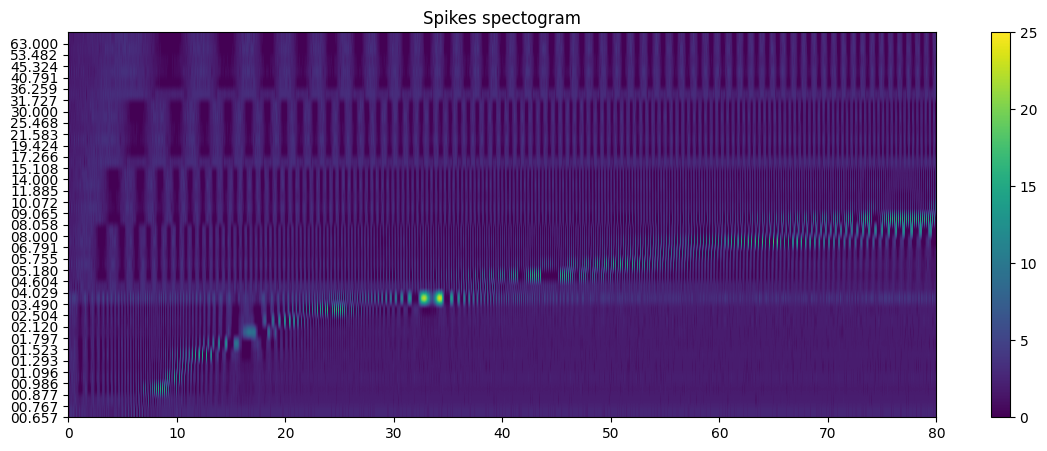

In [38]:
plot_spikes_spectogram(spikes_data)

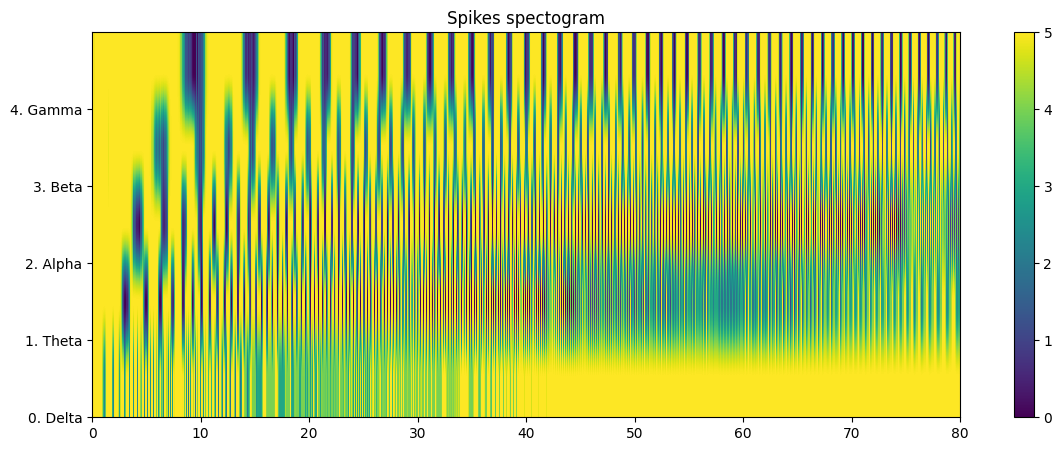

In [6]:
eeg_channels = {
    '0. Delta': sum(spikes_data[f].astype(bool)
                         for f in ['00.657', '01.523', '02.120', '02.504', '03.490']),
    '1. Theta': sum(spikes_data[f].astype(bool)
                         for f in ['04.604', '05.180', '05.755', '06.791', '08.000']),
    '2. Alpha': sum(spikes_data[f].astype(bool)
                         for f in ['08.058', '09.065', '10.072', '11.885', '14.000']),
    '3. Beta':  sum(spikes_data[f].astype(bool)
                         for f in ['15.108', '17.266', '19.424', '21.583', '25.468']),
    '4. Gamma': sum(spikes_data[f].astype(bool)
                         for f in ['36.259', '40.791', '45.324', '53.482', '63.000'])
}
plot_spikes_spectogram(eeg_channels)

In [ ]:
eeg_channels = {
    '0. Delta': sum(spikes_data[f].astype(np.int32)
                         for f in ['00.657', '01.523', '02.120', '02.504', '03.490']),
    '1. Theta': sum(spikes_data[f].astype(np.int32)
                         for f in ['04.604', '05.180', '05.755', '06.791', '08.000']),
    '2. Alpha': sum(spikes_data[f].astype(np.int32)
                         for f in ['08.058', '09.065', '10.072', '11.885', '14.000']),
    '3. Beta':  sum(spikes_data[f].astype(np.int32)
                         for f in ['15.108', '17.266', '19.424', '21.583', '25.468']),
    '4. Gamma': sum(spikes_data[f].astype(np.int32)
                         for f in ['36.259', '40.791', '45.324', '53.482', '63.000'])
}
plot_spikes_spectogram(eeg_channels)

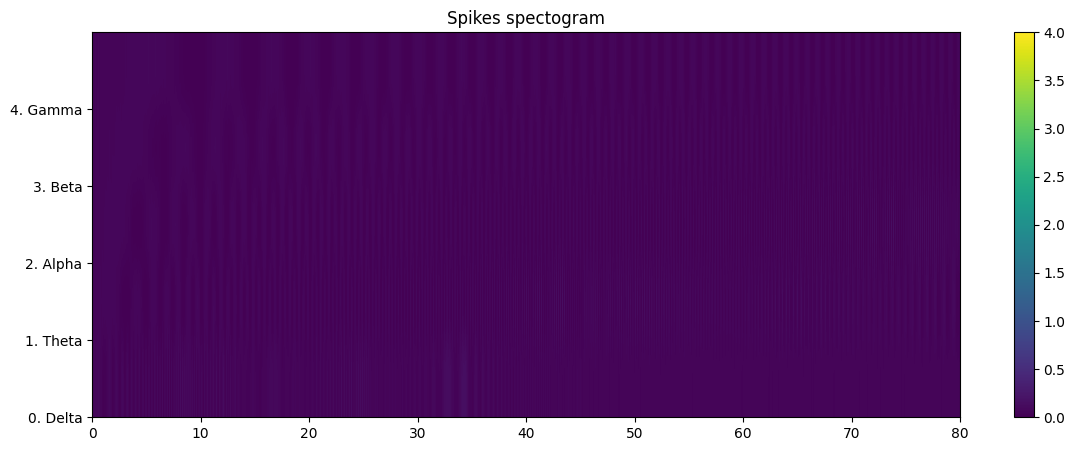

In [33]:
spikes_data = {
    ('0' * (6-len(filename[:-4]))) + filename[:-4]: np.load(f'../spikes_output/{filename}')['spikes'].astype(np.int8)
    for filename in os.listdir('../spikes_output')
}
eeg_channels = {
    '0. Delta': sum(spikes_data[f].astype(np.int32)
                         for f in ['00.877', '01.293', '01.523', '01.797', '02.504']),
    '1. Theta': sum(spikes_data[f].astype(np.int32)
                         for f in ['04.604', '05.180', '05.755', '06.791', '08.000']),
    '2. Alpha': sum(spikes_data[f].astype(np.int32)
                         for f in ['08.058', '09.065', '10.072', '11.885', '14.000']),
    '3. Beta':  sum(spikes_data[f].astype(np.int32)
                         for f in ['15.108', '17.266', '19.424', '21.583', '25.468']),
    '4. Gamma': sum(spikes_data[f].astype(np.int32)
                         for f in ['36.259', '40.791', '45.324', '53.482', '63.000'])
}
plot_spikes_spectogram(eeg_channels)

In [34]:
def plot_spikes_confusion_matrix(
        output_spikes,
):
    simulation_length = len(list(output_spikes.values())[0])
    confusion_matrix = np.zeros((5, 5))

    # Delta channel
    i_start = 0 * simulation_length // 80
    i_end = 4 * simulation_length // 80
    confusion_matrix[0, 0] = sum(output_spikes['0. Delta'][i_start:i_end])
    confusion_matrix[1, 0] = sum(output_spikes['1. Theta'][i_start:i_end])
    confusion_matrix[2, 0] = sum(output_spikes['2. Alpha'][i_start:i_end])
    confusion_matrix[3, 0] = sum(output_spikes['3. Beta'][i_start:i_end])
    confusion_matrix[4, 0] = sum(output_spikes['4. Gamma'][i_start:i_end])

    # Theta channel
    i_start = 4 * simulation_length // 80
    i_end = 8 * simulation_length // 80
    confusion_matrix[0, 1] = sum(output_spikes['0. Delta'][i_start:i_end])
    confusion_matrix[1, 1] = sum(output_spikes['1. Theta'][i_start:i_end])
    confusion_matrix[2, 1] = sum(output_spikes['2. Alpha'][i_start:i_end])
    confusion_matrix[3, 1] = sum(output_spikes['3. Beta'][i_start:i_end])
    confusion_matrix[4, 1] = sum(output_spikes['4. Gamma'][i_start:i_end])

    # Alpha channel
    i_start = 8 * simulation_length // 80
    i_end = 14 * simulation_length // 80
    confusion_matrix[0, 2] = sum(output_spikes['0. Delta'][i_start:i_end])
    confusion_matrix[1, 2] = sum(output_spikes['1. Theta'][i_start:i_end])
    confusion_matrix[2, 2] = sum(output_spikes['2. Alpha'][i_start:i_end])
    confusion_matrix[3, 2] = sum(output_spikes['3. Beta'][i_start:i_end])
    confusion_matrix[4, 2] = sum(output_spikes['4. Gamma'][i_start:i_end])

    # Beta channel
    i_start = 14 * simulation_length // 80
    i_end = 30 * simulation_length // 80
    confusion_matrix[0, 3] = sum(output_spikes['0. Delta'][i_start:i_end])
    confusion_matrix[1, 3] = sum(output_spikes['1. Theta'][i_start:i_end])
    confusion_matrix[2, 3] = sum(output_spikes['2. Alpha'][i_start:i_end])
    confusion_matrix[3, 3] = sum(output_spikes['3. Beta'][i_start:i_end])
    confusion_matrix[4, 3] = sum(output_spikes['4. Gamma'][i_start:i_end])

    # Gamma channel
    i_start = 30 * simulation_length // 80
    i_end = 63 * simulation_length // 80
    confusion_matrix[0, 4] = sum(output_spikes['0. Delta'][i_start:i_end])
    confusion_matrix[1, 4] = sum(output_spikes['1. Theta'][i_start:i_end])
    confusion_matrix[2, 4] = sum(output_spikes['2. Alpha'][i_start:i_end])
    confusion_matrix[3, 4] = sum(output_spikes['3. Beta'][i_start:i_end])
    confusion_matrix[4, 4] = sum(output_spikes['4. Gamma'][i_start:i_end])

    return confusion_matrix


cm = plot_spikes_confusion_matrix(eeg_channels)
cm

array([[ 230902.,  209836.,  328683.,  886232., 1838814.],
       [ 164666.,  227603.,  274542.,  742504., 1533431.],
       [ 164626.,  172986.,  347001.,  734226., 1534010.],
       [ 186747.,  179966.,  267789.,  917506., 1537502.],
       [ 173061.,  157533.,  238125.,  636887., 1861128.]])

In [35]:
cm[:, 0] /= 4
cm[:, 1] /= 4
cm[:, 2] /= 6
cm[:, 3] /= 16
cm[:, 4] /= 33

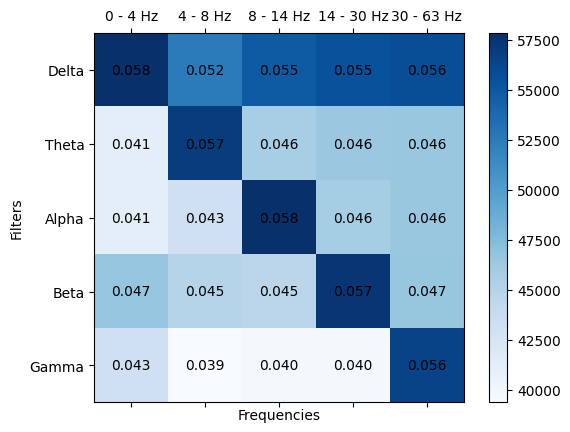

In [36]:

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set the x ticks to the top and set their labels
ax.tick_params(axis='x', labeltop=True, labelbottom=False, top=True)
# add labels for the x and y axes
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['0 - 4 Hz', '4 - 8 Hz', '8 - 14 Hz', '14 - 30 Hz', '30 - 63 Hz'])
ax.set_yticklabels(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])


plt.xlabel('Frequencies')
plt.ylabel('Filters')


# add the values of the matrix to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, f'{cm[i, j]/1e6:.3f}',
                       ha="center", va="center", color="black")

# add a color bar to the plot
cbar = ax.figure.colorbar(im, ax=ax)

# show the plot
plt.show()

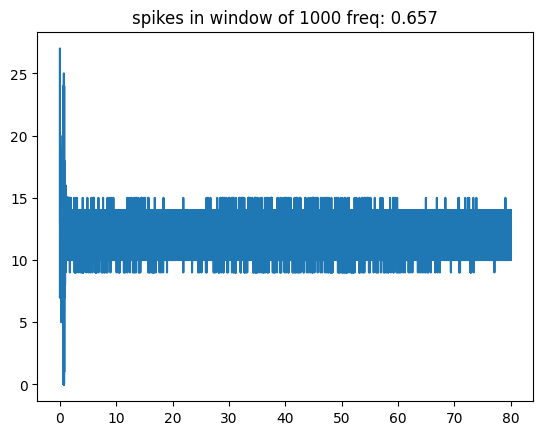

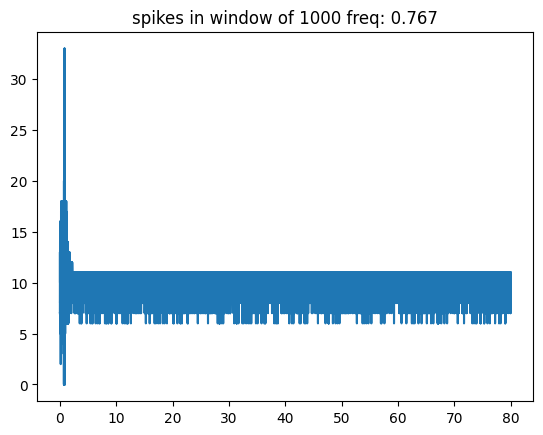

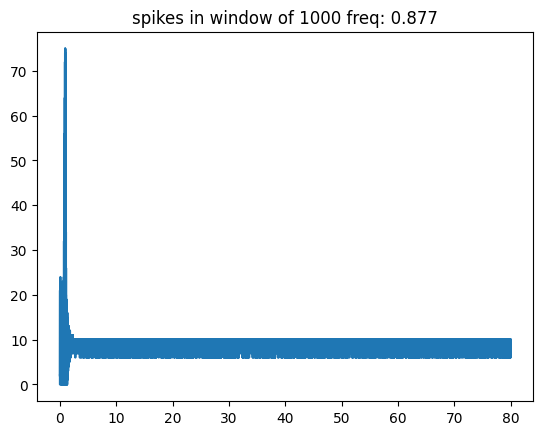

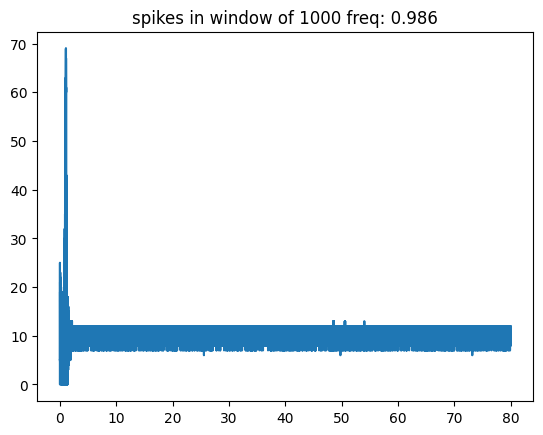

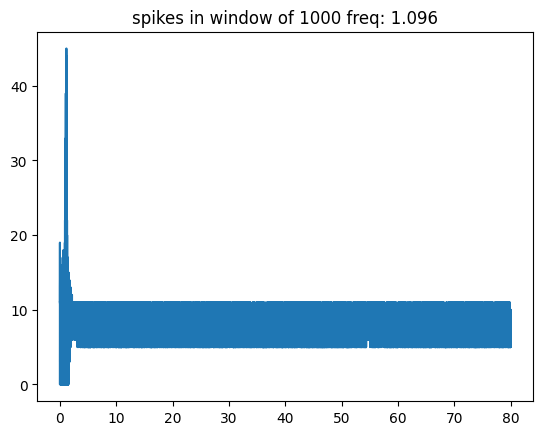

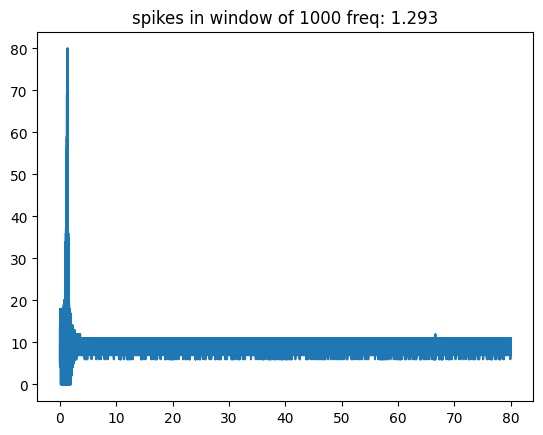

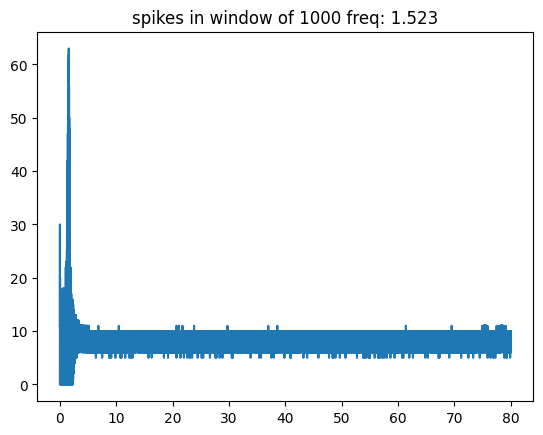

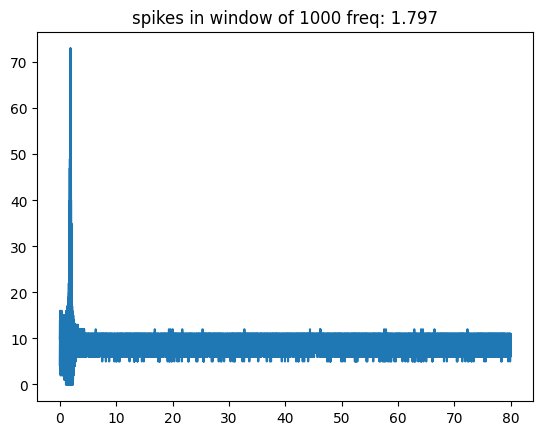

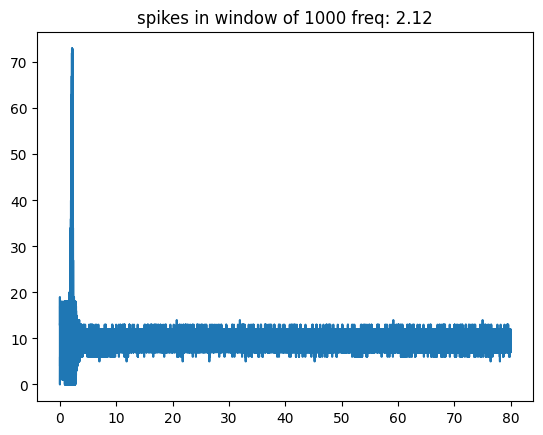

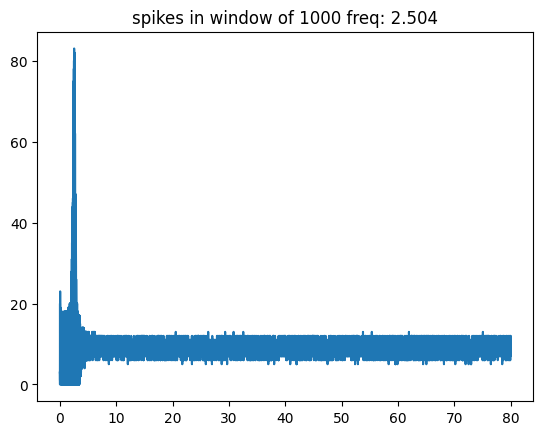

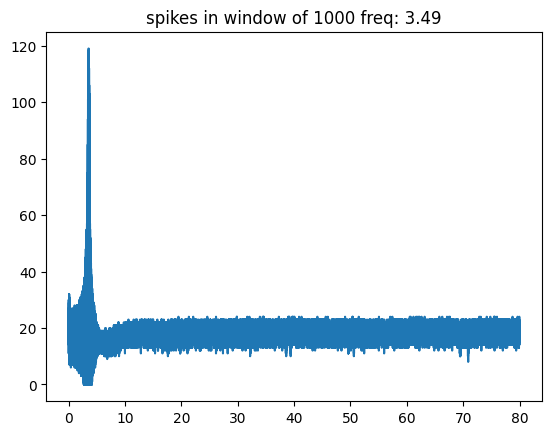

In [28]:
filters = [0.657, 0.767, 0.877, 0.986, 1.096, 1.293, 1.523, 1.797, 2.120, 2.504, 3.490]
swindow = 1000
for f in filters:
    spikes = np.load(f'../spikes_output/{f:.3f}.npz')['spikes'].astype(np.int8)
    spikes = np.convolve(spikes, np.ones(swindow, dtype=np.int16), 'valid')
    x = np.linspace(0, 80, len(spikes))
    plt.title(f'spikes in window of {swindow} freq: {f}')
    plt.plot(x, spikes)
    plt.show()

In [ ]:
['00.877', '01.293', '01.523', '01.797', '02.504']